In [ ]:
library(tidyverse)
library(data.table)
library(plotly) # for interactive ploting
library(DT) # for interactive tabulation

In [ ]:
options(repr.matrix.max.rows=20, repr.matrix.max.cols=15) # for limiting the number of top and bottom rows of tables printed 

In [ ]:
datapath <- "../data"

# World Shares, High-Income vs Mid Income

Please first import the objects for the WEO dataset: 

In [ ]:
# wide data with features in the columns and countries/years in the rows
weo_wide2 <- readRDS(sprintf("%s/rds/01_01_weo_wide2.rds", datapath))

In [ ]:
weo_countries <- readRDS(sprintf("%s/rds/01_01_weo_countries.rds", datapath))
weo_subject <- readRDS(sprintf("%s/rds/01_01_weo_subject.rds", datapath))

Remember the nice widget to navigate through and search in tabular data:

In [ ]:
weo_subject %>% datatable(
  filter = "top",
  options = list(pageLength = 20)
)

We created a plot that shortly said:

The total income created in the world is becoming more concentrated in the hands of fewer countries as per HHI index since 2008: 

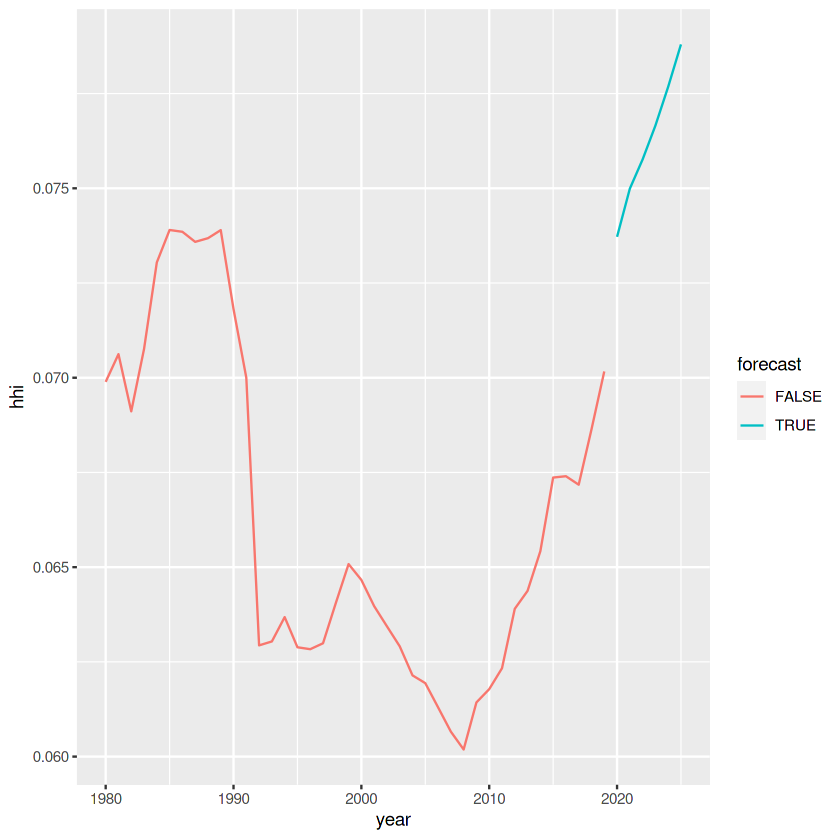

A global crisis started in 2007 and deepened in 2008.

The first spark was ignited in the subprime mortgage market in the USA and the financial sector was hit hard by the crisis.

Developed countries with larger and more complicated financial sectors were more affected by the crisis while developing countries with more shallow financial sectors were protected to some degree from the consequences.

So many of the largest developed countries (such as G7) lost their weight in world economy while some of the largest developing countries increased their weights.

Your task is to visualize this phenomenon following the steps:

- From the dataset and subject descriptions find a good measure of true income level to differentiate the development phase across countries.
- Optionally select only those features (codes, year, income level, world share) and assign to a new object
- Using the income levels for a certain year and using `cut()` function, create a factor variable with "low", "medium" and "high" income levels for each country. You may also use `quantile()` function to determine the break points. You are free to choose the method to make the classification but state your method explicitly. Have a new data.table of country codes and income level factors at the end. We assume that the income level classification of a country is fixed through out the dataset for all years.
- Create a sharerank variable for the rank of the world shares (smaller the rank larger the share) for each year of the dataset (just like we did last week)
- Filter for the countries with 20 largest economies for each year (just like we did last week)
- Merge the data and the income level table using country codes (ISO) as the common field
- Create a line plot with this data as such:
    - Data for 2008 and onwards will be included
    - Each country's data will be a separate line while the high and medium income level countries will be shown with different colors (using group and color aesthetics of ggplot)
    
An example output will look similar to (but not necessarily exactly like) the following plot:

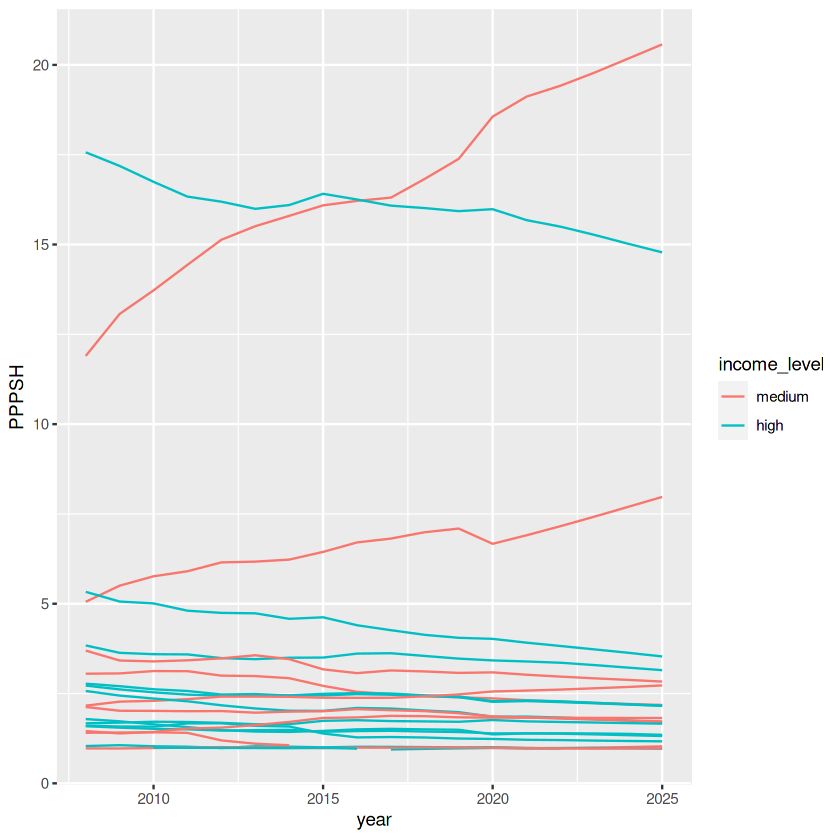

- Display both the static ggplot and the interactive plotly version of the plots

## Answer

Select the necessary features

In [ ]:
features <- c("PPPSH", "NGDPRPPPPC")

See what they are:

In [ ]:
weo_subject[WEO_Subject_Code %in% features]

Extract necessary columns:

In [ ]:
weo_ppp <- weo_wide2 %>%
    select(all_of(c("ISO", "year", features)))

In [ ]:
weo_ppp

For year 2019 data (last actual data), create income level factor for 0.25 and 0.75 quantiles on income per capita

In [ ]:
income_levels <- weo_ppp[year == 2019, .(ISO, NGDPRPPPPC)] %>%
mutate(income_level = cut(NGDPRPPPPC,
                              quantile(c(-Inf, NGDPRPPPPC, Inf),
                                       c(0, 0.25, 0.75, 1), na.rm = T),
                              label = c("low", "medium", "high"))) %>%
select(-NGDPRPPPPC)

In [ ]:
income_levels

Create a column for share ranks for each year:

In [ ]:
weo_ppp[, sharerank := frank(-PPPSH, ties.method = "first"), by = year]

Join the data and the levels

In [ ]:
weo_rank <- weo_ppp %>% inner_join(income_levels, by = "ISO") %>% filter(sharerank <= 20)

In [ ]:
weo_rank

Create the plot.

Optionally the shares can be converted to log so that lines with smaller values are easily identified separately:

In [ ]:
wrp1 <- weo_rank %>% 
#mutate(PPPSH = log(PPPSH)) %>%
filter(year >= 2008) %>%
ggplot(aes(x = year, y = PPPSH, group = ISO, color = income_level)) +
geom_line()

In [ ]:
wrp1

In [ ]:
wrp1 %>% ggplotly